# Problem Statement 4: Data Analysis

For this problem, I have decided to utilize the crimes against women [dataset](https://www.kaggle.com/datasets/balajivaraprasad/crimes-against-women-in-india-2001-2021?resource=download&select=CrimesOnWomenData.csv) available on Kaggle.

Due to time restriction, I couldn't analyze it deeper.

In [ ]:
!pip install geopandas matplotlib --quiet

In [ ]:
import pandas as pd
crimes = pd.read_csv("/content/CrimesOnWomenData.csv")
crimes.head()

Unnamed: 0              State  Year  Rape   K&A   DD   AoW   AoM    DV  WT
0           0     ANDHRA PRADESH  2001   871   765  420  3544  2271  5791   7
1           1  ARUNACHAL PRADESH  2001    33    55    0    78     3    11   0
2           2              ASSAM  2001   817  1070   59   850     4  1248   0
3           3              BIHAR  2001   888   518  859   562    21  1558  83
4           4       CHHATTISGARH  2001   959   171   70  1763   161   840   0

In [ ]:
crimes = crimes.rename(columns={
    'K&A': 'Kidnap And Assault',
    'DD': 'Dowry Deaths',
    'AoW': 'Assault against women',
    'AoM': 'Assault against modesty of women',
    'DV': 'Domestic violence',
    'WT': 'Women Trafficking'
})
crimes = crimes.drop(crimes.columns[0], axis=1)

crimes.head()

State  Year  Rape  Kidnap And Assault  Dowry Deaths  \
0     ANDHRA PRADESH  2001   871                 765           420   
1  ARUNACHAL PRADESH  2001    33                  55             0   
2              ASSAM  2001   817                1070            59   
3              BIHAR  2001   888                 518           859   
4       CHHATTISGARH  2001   959                 171            70   

   Assault against women  Assault against modesty of women  Domestic violence  \
0                   3544                              2271               5791   
1                     78                                 3                 11   
2                    850                                 4               1248   
3                    562                                21               1558   
4                   1763                               161                840   

   Women Trafficking  
0                  7  
1                  0  
2                  0  
3                 83  
4                  0

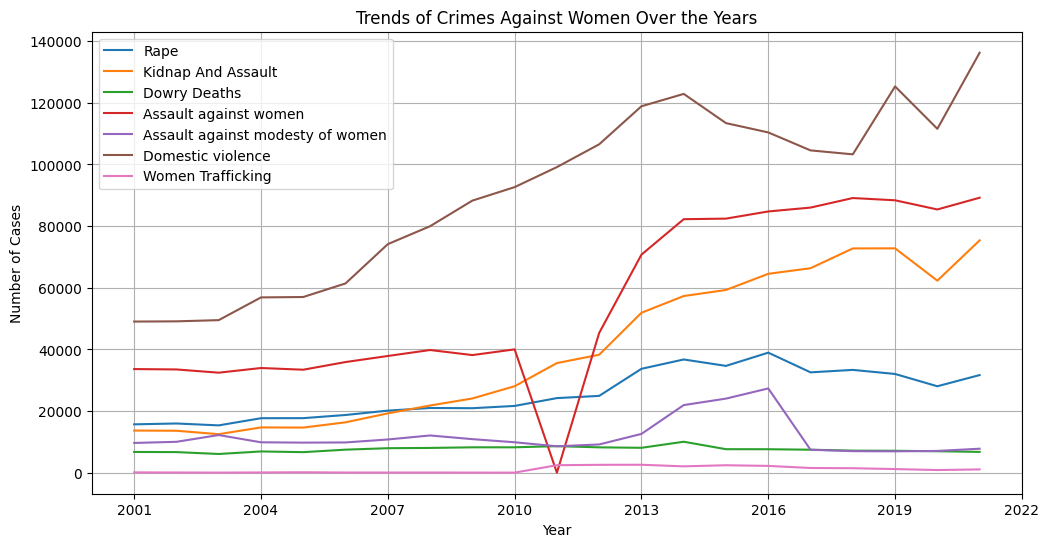

In [ ]:
import matplotlib.pyplot as plt

# Group the data by year and sum the crime cases for each year
yearly_data = crimes.groupby('Year')[['Rape', 'Kidnap And Assault', 'Dowry Deaths', 'Assault against women', 'Assault against modesty of women', 'Domestic violence', 'Women Trafficking']].sum()

# Plot the data
plt.figure(figsize=(12, 6))
for column in yearly_data.columns:
    plt.plot(yearly_data.index, yearly_data[column], label=column)

plt.title('Trends of Crimes Against Women Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.show()

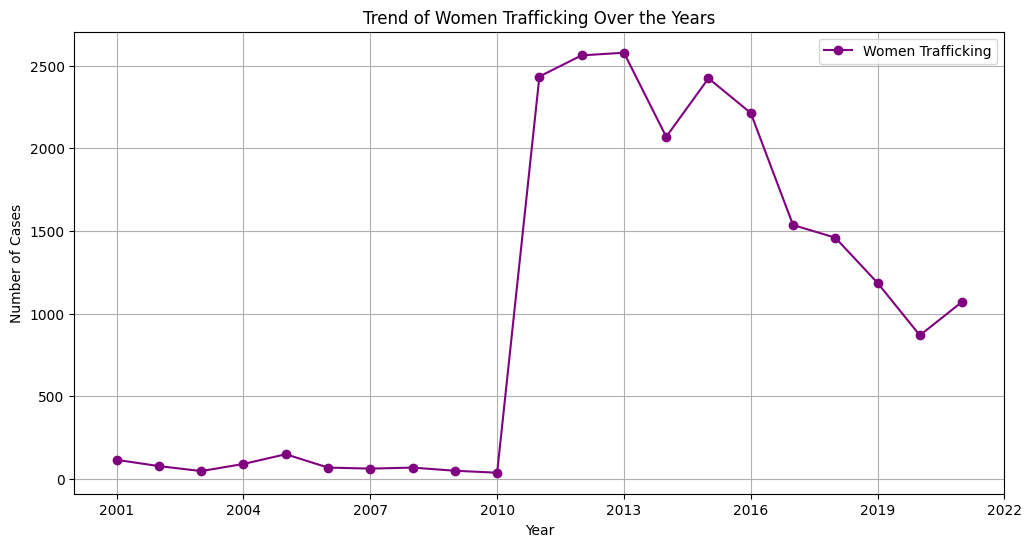

In [ ]:
# Plot Women Trafficking over the years
plt.figure(figsize=(12, 6))
plt.plot(yearly_data.index, yearly_data['Women Trafficking'], marker='o', color='purple', label='Women Trafficking')

plt.title('Trend of Women Trafficking Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.grid(True)

# Fix the x-axis to show years as integers
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.legend()
plt.show()

Top 10 worst and best states for women over the last 20 years

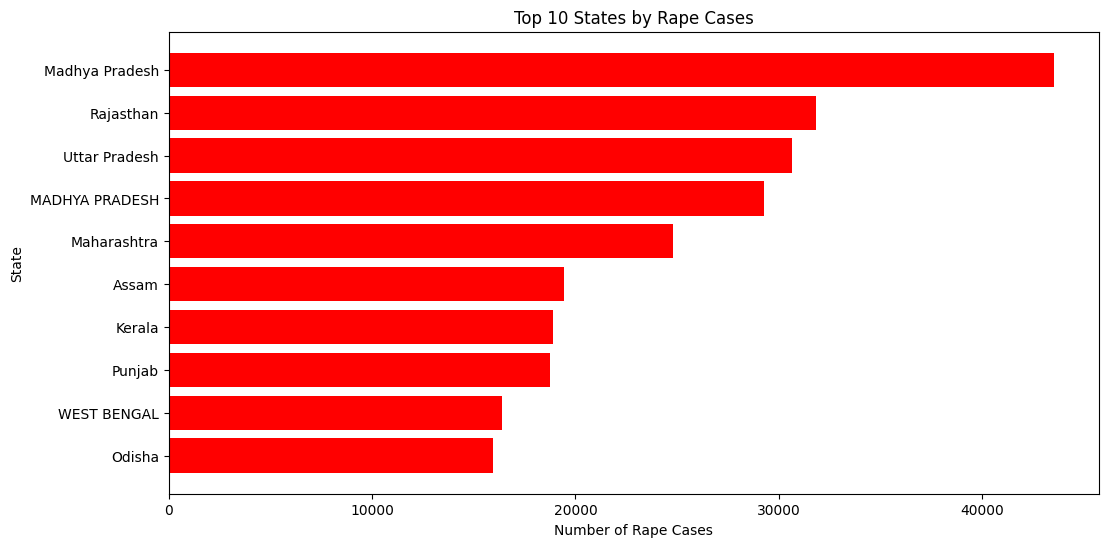

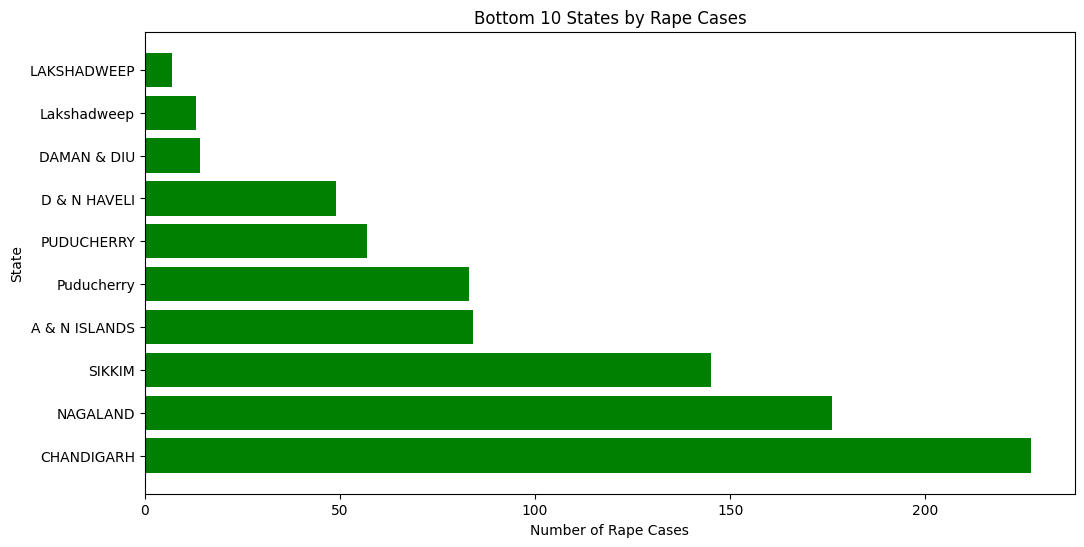

In [ ]:
total_rape_cases = crimes.groupby('State')['Rape'].sum().reset_index()

# Sort to get the top and bottom 10 states
top_10_states = total_rape_cases.nlargest(10, 'Rape')
bottom_10_states = total_rape_cases.nsmallest(10, 'Rape')

# Plot the top 10 states
plt.figure(figsize=(12, 6))
plt.barh(top_10_states['State'], top_10_states['Rape'], color='red')
plt.title('Top 10 States by Rape Cases')
plt.xlabel('Number of Rape Cases')
plt.ylabel('State')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# Plot the bottom 10 states
plt.figure(figsize=(12, 6))
plt.barh(bottom_10_states['State'], bottom_10_states['Rape'], color='green')
plt.title('Bottom 10 States by Rape Cases')
plt.xlabel('Number of Rape Cases')
plt.ylabel('State')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# Problem Statement 5: Live Coding Session - API Integration

For this problem, I have decided to scrape youtube. You will need a API key which can be create [here](https://support.google.com/googleapi/answer/6158862?hl=en). Please replace YOUR_API_KEY with the key. There are 6 places where you need to put the api key in the next code block

Get the channel id of any youtube channel by going to the channels main page, right click and select view page source. This will open another page. Here search(ctrl+f) for ?channel_id=
The string after that will be channel id.

I have scraped the entire channel, which includes all the videos, comments, description etc

In [35]:
import pandas as pd
import requests

# Function to fetch comments for a given video ID
def comments_func(id):
    comments_url = f'https://www.googleapis.com/youtube/v3/commentThreads?part=snippet&videoId={id}&maxResults=50&key=YOUR_API_KEY'
    comments_data = requests.get(comments_url)
    json_comments_data = comments_data.json()
    comments = {}

    # Loop through comments and store them
    while 'items' in json_comments_data and json_comments_data['items']:
        for item in json_comments_data['items']:
            comment_id = item['id']
            comment_text = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comment_author = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
            comment_publishedat = item['snippet']['topLevelComment']['snippet']['publishedAt']

            comment_data = {
                "Comment_Id": comment_id,
                "Comment_Text": comment_text,
                "Comment_Author": comment_author,
                "Comment_PublishedAt": comment_publishedat
            }

            comments[f"Comment_Id_{len(comments) + 1}"] = comment_data

        # Check for next page of comments
        if 'nextPageToken' in json_comments_data:
            next_page_token = json_comments_data['nextPageToken']
            next_page_URL = f'https://www.googleapis.com/youtube/v3/commentThreads?part=snippet&videoId={id}&maxResults=50&pageToken={next_page_token}&key=YOUR_API_KEY'
            next_page_comments = requests.get(next_page_URL)
            json_comments_data = next_page_comments.json()
        else:
            break

    return comments

# Function to fetch video data for a list of video IDs
def videos_func(list_of_video_ids):
    videos_data_dict = {}  # Dictionary to store data for all videos

    for id in list_of_video_ids:
        video_data_URL = f'https://www.googleapis.com/youtube/v3/videos?part=snippet,contentDetails,statistics&id={id}&key=YOUR_API_KEY'
        video_data = requests.get(video_data_URL)
        json_video_data = video_data.json()

        # Check if video data is available
        if 'items' in json_video_data and len(json_video_data['items']) > 0:
            videos_data_dict[f"Video_Id_{len(videos_data_dict) + 1}"] = {
                "Video_Id": id,
                "Video_Name": json_video_data['items'][0]['snippet']['title'],
                "Video_Description": json_video_data['items'][0]['snippet']['description'],
                "Tags": json_video_data['items'][0]['snippet'].get('tags', []),
                "PublishedAt": json_video_data['items'][0]['snippet']['publishedAt'],
                "View_Count": json_video_data['items'][0]['statistics']['viewCount'],
                "Like_Count": json_video_data['items'][0]['statistics']['likeCount'],
                "Dislike_Count": json_video_data['items'][0]['statistics'].get('dislikeCount', 0),
                "Favorite_Count": json_video_data['items'][0]['statistics']['favoriteCount'],
                "Comment_Count": json_video_data['items'][0]['statistics'].get('commentCount', 0),
                "Duration": json_video_data['items'][0]['contentDetails']['duration'],
                "Thumbnail": json_video_data['items'][0]['snippet']['thumbnails']['default']['url'],
                "Caption_Status": json_video_data['items'][0]['contentDetails']['caption'],
                "Comments": comments_func(id)  # Fetch comments for each video
            }

    return videos_data_dict

# Main function to fetch channel and video data
def main():
    input_id = input("Please input the ID of the YouTube channel: ")

    URL = f'https://www.googleapis.com/youtube/v3/channels?part=id,snippet,statistics,contentDetails,status&id={input_id}&key=YOUR_API_KEY'
    r = requests.get(URL)
    json_data = r.json()
    if 'items' in json_data and json_data['items']:
        channel_data = {
            'channel_name': json_data['items'][0]['snippet']['title'],
            'channel_id': json_data['items'][0]['id'],
            'Subscription_Count': json_data['items'][0]['statistics']['subscriberCount'],
            'channel_views': json_data['items'][0]['statistics']['viewCount'],
            'channel_description': json_data['items'][0]['snippet']['description'],
            'playlist_id': json_data['items'][0]['contentDetails']['relatedPlaylists']['uploads']
        }

        # Fetch video IDs from the channel's upload playlist
        playlist_id = json_data['items'][0]['contentDetails']['relatedPlaylists']['uploads']
        playlist_items_url = f'https://www.googleapis.com/youtube/v3/playlistItems?part=id,contentDetails,snippet&playlistId={playlist_id}&maxResults=50&key=YOUR_API_KEY'
        videos_id = requests.get(playlist_items_url)
        json_video_ids = videos_id.json()
        list_of_video_ids = [item['contentDetails']['videoId'] for item in json_video_ids['items']]

        # Handle pagination for video IDs
        while 'nextPageToken' in json_video_ids and 'items' in json_video_ids:
            if 'nextPageToken' in json_video_ids:
                nextPageToken = json_video_ids.get('nextPageToken')
                URL_next_page = f'https://www.googleapis.com/youtube/v3/playlistItems?part=contentDetails&playlistId={playlist_id}&maxResults=50&pageToken={nextPageToken}&key=YOUR_API_KEY'
                next_page_response = requests.get(URL_next_page)
                json_video_ids = next_page_response.json()
                list_of_video_ids.extend([item['contentDetails']['videoId'] for item in json_video_ids['items']])
            else:
                break

        # Combine channel and video data
        result_dict = channel_data.copy()
        result_dict.update({'videos_data': videos_func(list_of_video_ids)})

        # Store the result globally
        global result_dict_out
        result_dict_out = result_dict
        print("Output")
        print(result_dict)

if __name__ == "__main__":
    main()

Please input the ID of the YouTube channel: UCfGDYIyyNh52lvU4rCJkInA
Output
{'channel_name': 'Kiyan Sobhani: Real Madrid Journalist', 'channel_id': 'UCfGDYIyyNh52lvU4rCJkInA', 'Subscription_Count': '11600', 'channel_views': '3384969', 'channel_description': "Kiyan Sobhani is a Real Madrid journalist who also covers Spanish football. He has press access to matches, training, and Castilla. He is also an author of the upcoming book 'Holy Book of Madridismo -- The Ultimate Real Madrid Fan Manifesto'. Kiyan is the chief editor of Managing Madrid, runs the largest Real Madrid podcast in the world (The Managing Madrid Podcast), and does work for FourFourTwo, StatsBomb, and Tifo Football. He is also co-host of 'Churros y Tácticas' -- a Spanish football podcast -- and co-founded the 'School of Real Madrid' YouTube channel.\n\nOn this channel, you'll find journalism advice, Real Madrid analysis, Q&A's, and an inside look at Kiyan's travels covering Real Madrid.", 'playlist_id': 'UUfGDYIyyNh52lvU

In [ ]:
import pandas as pd

result_dict = result_dict_out

# Extract video data
videos_data = result_dict.pop('videos_data')

# Convert video data to DataFrame
videos_df = pd.DataFrame.from_dict(videos_data, orient='index')

# Convert other channel info to a DataFrame
channel_info_df = pd.DataFrame([result_dict])



In [39]:
channel_info_df.head()

channel_name                channel_id  \
0  Kiyan Sobhani: Real Madrid Journalist  UCfGDYIyyNh52lvU4rCJkInA   

  Subscription_Count channel_views  \
0              11600       3384969   

                                 channel_description               playlist_id  
0  Kiyan Sobhani is a Real Madrid journalist who ...  UUfGDYIyyNh52lvU4rCJkInA

In [41]:
videos_df.head()

Video_Id                                         Video_Name  \
Video_Id_1  uJ0qk15D9aE  Ballon D'or Award Favourites, Rodrygo Instagra...   
Video_Id_2  uhSn7EnQiRE                    Aura battle: Zidane v Iniesta 🤔   
Video_Id_3  nRjWDqAd_8s  Are Barca Peaking Too Early? Real Madrid Arivi...   
Video_Id_4  fsqevAFWhYU                   Do haircuts make a difference? 🤣   
Video_Id_5  3YBMEp4YHmo  Real Madrid Live Stream: International Break U...   

           Video_Description Tags           PublishedAt View_Count Like_Count  \
Video_Id_1                     []  2024-09-05T06:08:09Z       1675         93   
Video_Id_2                     []  2024-09-05T01:05:52Z        422         14   
Video_Id_3                     []  2024-09-04T17:19:31Z       2213         82   
Video_Id_4                     []  2024-09-04T15:26:20Z        807         28   
Video_Id_5                     []  2024-09-03T18:07:36Z          0          0   

            Dislike_Count Favorite_Count Comment_Count  Duration  \
Video_Id_1              0              0            43  PT51M38S   
Video_Id_2              0              0             1     PT32S   
Video_Id_3              0              0             8  PT53M34S   
Video_Id_4              0              0             3     PT38S   
Video_Id_5              0              0             0       P0D   

                                                    Thumbnail Caption_Status  \
Video_Id_1     https://i.ytimg.com/vi/uJ0qk15D9aE/default.jpg          false   
Video_Id_2     https://i.ytimg.com/vi/uhSn7EnQiRE/default.jpg          false   
Video_Id_3     https://i.ytimg.com/vi/nRjWDqAd_8s/default.jpg          false   
Video_Id_4     https://i.ytimg.com/vi/fsqevAFWhYU/default.jpg          false   
Video_Id_5  https://i.ytimg.com/vi/3YBMEp4YHmo/default_liv...          false   

                                                     Comments  
Video_Id_1  {'Comment_Id_1': {'Comment_Id': 'Ugz7b3tpH0hmT...  
Video_Id_2  {'Comment_Id_1': {'Comment_Id': 'UgxCct2Kaxklo...  
Video_Id_3  {'Comment_Id_1': {'Comment_Id': 'Ugx8xi4CK97HJ...  
Video_Id_4  {'Comment_Id_1': {'Comment_Id': 'UgysWEwrZTy1v...  
Video_Id_5                                                 {}